In [2]:
import os
import sys

import time
import numpy as np
import pandas as pd
import pickle as pkl

import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.data import Data, Batch

from itertools import cycle
from sklearn.metrics import roc_curve, auc
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

from tqdm.notebook import tqdm

import xai4hep
from xai4hep.particlenet import ParticleNet
from xai4hep.particlenet.fastjet_utils import get_subjets

In [3]:
%load_ext autoreload
%autoreload 2

# Make dR plot in the paper

In [28]:
! ls ParticleNet_6/

Rscores_0                   Rscores_9
Rscores_1                   Rscores_best
Rscores_2                   Rscores_best_10k
Rscores_3                   before_training_weights.pth
Rscores_4                   best_epoch_weights.pth
Rscores_5                   epoch_0_weights.pth
Rscores_6                   hyperparameters.txt
Rscores_7                   model_kwargs.pkl
Rscores_8                   weights


In [29]:
def get_dr_plot(trained):
    
    dr_top, dr_qcd = [], []
        
    if trained:
        loops = 1    
    else:
        loops = 10
        
    for loop, models in enumerate(range(loops)):
        
        if trained:
            PATH = "ParticleNet_6/Rscores_best_10k"                                           
        else:
            PATH = f"ParticleNet_6/Rscores_{loop}"

        with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
            batch_x_list = pkl.load(handle)
        with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
            batch_y_list = pkl.load(handle)

        with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
            R_edges_list = pkl.load(handle)    
        with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
            edge_index_list = pkl.load(handle)

        with open(f'{PATH}/batch_px.pkl', 'rb') as handle:
            batch_px_list = pkl.load(handle)
        with open(f'{PATH}/batch_py.pkl', 'rb') as handle:
            batch_py_list = pkl.load(handle)  
        with open(f'{PATH}/batch_pz.pkl', 'rb') as handle:
            batch_pz_list = pkl.load(handle)
        with open(f'{PATH}/batch_E.pkl', 'rb') as handle:
            batch_E_list = pkl.load(handle)     

        print(f'loop {loop}')
        for i in tqdm(range(len(batch_y_list))):
            jet_label = batch_y_list[i]
            jet_input = batch_x_list[i]

            R_edges = R_edges_list[i]
            edge_index = edge_index_list[i]

            if trained:        
                R_edges = R_edges['edge_conv_2']
                edge_index = edge_index['edge_conv_2']

            px = batch_px_list[i]
            py = batch_py_list[i]
            pz = batch_pz_list[i]
            e = batch_E_list[i]

            p = torch.sqrt(torch.square(px) + torch.square(py) + torch.square(pz))

            # recall: Features, in order: [eta, phi, pt, mask].
            eta = jet_input[:, 0]
            phi = jet_input[:, 1]
            pt = np.abs(jet_input[:, 2])

            eta_phi = jet_input[:, :2]

            # build graph
            edge_index, edge_weight = edge_index, torch.abs(R_edges).sum(axis=1)
            edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1

            def deltaR(eta1, eta2, phi1, phi2):
                return torch.sqrt(torch.square(eta2-eta1) + torch.square(phi2-phi1))

            top_5_edges = torch.topk(edge_Rscores, 5).indices   # pick top 5 edge Rscores, get the indices

            for edge in top_5_edges:
                particle_1 = edge_index[0][edge]
                particle_2 = edge_index[1][edge]

                px1 = px[particle_1]
                py1 = py[particle_1]
                pz1 = pz[particle_1]

                px2 = px[particle_2]
                py2 = py[particle_2]
                pz2 = pz[particle_2]

                eta1 = eta[particle_1]
                eta2 = eta[particle_2]

                phi1 = phi[particle_1]
                phi2 = phi[particle_2]

                e1 = e[particle_1]
                e2 = e[particle_2]

                M12 = torch.sqrt(torch.square(e1+e2) - torch.square(px1+ px2) - torch.square(py1+py2) - torch.square(pz1+pz2))

                if jet_label==1:
                    dr_top.append(deltaR(eta1, eta2, phi1, phi2).item())
                else:
                    dr_qcd.append(deltaR(eta1, eta2, phi1, phi2).item())

    return dr_top, dr_qcd

## Make and save

In [ ]:
dr_top_trained, dr_qcd_trained = get_dr_plot(trained=True)

with open('paper/dr_top_trained.pkl', 'wb') as f:
    pkl.dump(dr_top_trained, f)
with open('paper/dr_qcd_trained.pkl', 'wb') as f:
    pkl.dump(dr_qcd_trained, f)

In [ ]:
dr_top_untrained, dr_qcd_untrained = get_dr_plot(trained=False)

with open('paper/dr_top_untrained.pkl', 'wb') as f:
    pkl.dump(dr_top_untrained, f)
with open('paper/dr_qcd_untrained.pkl', 'wb') as f:
    pkl.dump(dr_qcd_untrained, f) 

## Load and plot

In [33]:
# load the trained vars
with open('paper/dr_top_trained.pkl', 'rb') as f:
    dr_top_trained = pkl.load(f)
with open('paper/dr_qcd_trained.pkl', 'rb') as f:
    dr_qcd_trained = pkl.load(f)
    
# load the untrained values
with open('paper/dr_top_untrained.pkl', 'rb') as f:
    dr_top_untrained = pkl.load(f)
with open('paper/dr_qcd_untrained.pkl', 'rb') as f:
    dr_qcd_untrained = pkl.load(f)

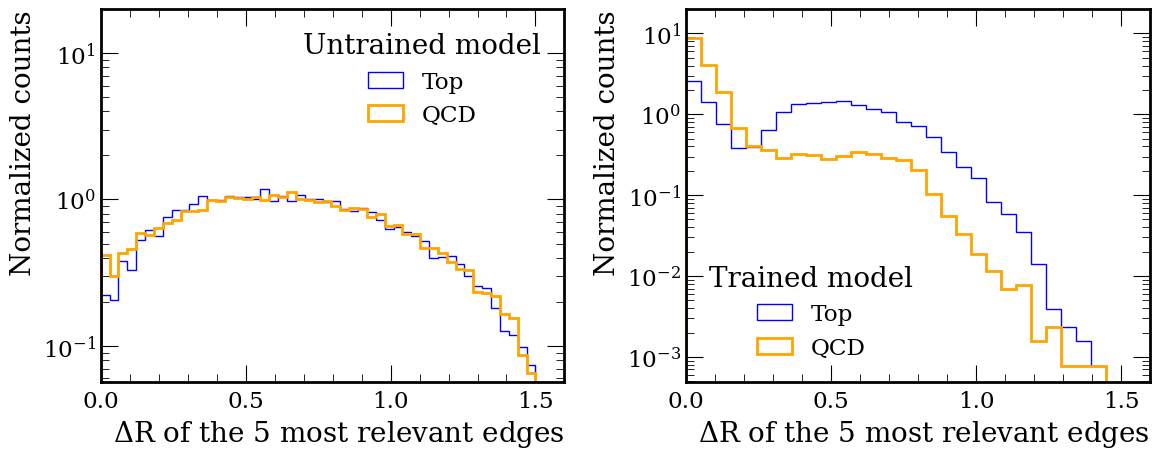

In [43]:
from matplotlib.font_manager import FontProperties
import warnings

warnings.filterwarnings("ignore")
font = FontProperties()
# font.set_family('serif')
font.set_name('Times New Roman')
plt.rcParams.update({'font.family':'serif'}) 
    
# make the plot
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
counts, bins, _ = axes[0].hist(dr_top_untrained, bins=np.linspace(0, 1.5, 50), label='Top', color="Blue", histtype='step', linewidth=1, density=True)
# err = np.sqrt(counts)
# axes[0].errorbar(bins[:-1], counts, yerr=err)
counts, bins, _ = axes[0].hist(dr_qcd_untrained, bins=np.linspace(0, 1.5, 50), label='QCD', color="Orange", histtype='step', linewidth=2, density=True)
# err = np.sqrt(counts)
# axes[0].errorbar(bins[:-1], counts, yerr=err)
axes[0].legend(title='Untrained model')
axes[0].set_yscale('log') 
axes[0].set_ylim(0,20)
axes[0].set_xlim(0,1.6)
axes[0].set_xticks([0,0.5,1,1.5])
axes[0].set_xlabel('$\Delta$R of the 5 most relevant edges')
axes[0].set_ylabel('Normalized counts')

axes[1].hist(dr_top_trained, bins=np.linspace(0, 1.5, 30), label='Top', color="Blue", histtype='step', linewidth=1, density=True)
axes[1].hist(dr_qcd_trained, bins=np.linspace(0, 1.5, 30), label='QCD', color="Orange", histtype='step', linewidth=2, density=True)
axes[1].legend(title='Trained model')
axes[1].set_yscale('log') 
axes[1].set_ylim(0,20)
axes[1].set_xlim(0,1.6)
axes[1].set_xticks([0,0.5,1,1.5])
axes[1].set_xlabel('$\Delta$R of the 5 most relevant edges')
axes[1].set_ylabel('Normalized counts')

fig.tight_layout()

plt.savefig('paper/deltaR.pdf')
plt.show()

# Make scaling up plot in the paper

In [15]:
# this function can be found here https://github.com/farakiko/xai4hep/blob/dev/xai4hep/particlenet/fastjet_utils.py#L110
# a few changes are made to make it compatible with the old code
# the old code saved Rscores and p4 values in a non-optimal way

def scaling_up(trained):
    """
    Computes the distribution of edges connecting different subjets for different values of N.

    Args:
        outpath [str]: Path to load the Rscores pkl files
        epoch [int]: The epoch at which to load the model
            (if -1: best trained model, if 0: untrained model, otherwise loads the corresponding epoch)
        N_values [int]: The different values of N to scan, which will be taken as range(N_values)
            (default is 15)
        N_SUBJETS [int]: Number of subjets to decluster the jet into
            (default is 3)
        JET_ALGO [str]: The jet declustering algorithm to use. Choices are ["CA", "kt", "antikt"]
            (default is "CA")
        jet_radius [float]: The jet radius to use when declustering
            (default is 0.8)

    """
    
    N_values=15
    N_SUBJETS=3
    JET_ALGO="CA"
    jet_radius=0.8

    # same: list of counters, for each N, of edges connecting the same subjet
    top_same, qcd_same = np.array([0] * N_values), np.array([0] * N_values)
    # diff: list of counters, for each N, of edges connecting different subjets
    top_diff, qcd_diff = np.array([0] * N_values), np.array([0] * N_values)
    
    if trained:
        loops = 1 
    else:
        loops = 10
        
    for loop, models in enumerate(range(loops)):
        
        if trained:
            PATH = "ParticleNet_6/Rscores_best_10k"
            
        else:
            PATH = f"ParticleNet_6/Rscores_{loop}"
        
        print(f"Using Rscores computed here: {PATH}")

        with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
            batch_x_list = pkl.load(handle)
        with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
            batch_y_list = pkl.load(handle)

        with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
            R_edges_list = pkl.load(handle)    
        with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
            edge_index_list = pkl.load(handle)

        with open(f'{PATH}/batch_px.pkl', 'rb') as handle:
            batch_px_list = pkl.load(handle)
        with open(f'{PATH}/batch_py.pkl', 'rb') as handle:
            batch_py_list = pkl.load(handle)  
        with open(f'{PATH}/batch_pz.pkl', 'rb') as handle:
            batch_pz_list = pkl.load(handle)
        with open(f'{PATH}/batch_E.pkl', 'rb') as handle:
            batch_E_list = pkl.load(handle)     
        
        Num_jets = len(batch_E_list)

        print(f"Total # of jets is {Num_jets}")
        for i in range(Num_jets):
            # define the jet information
            jet_label = batch_y_list[i]

            px = batch_px_list[i]
            py = batch_py_list[i]
            pz = batch_pz_list[i]
            e = batch_E_list[i]
            
            if trained:
                edge_Rscores = torch.abs(R_edges_list[i]["edge_conv_2"]).sum(axis=1) / sum(torch.abs(R_edges_list[i]["edge_conv_2"]).sum(axis=1))
                edge_index = edge_index_list[i]["edge_conv_2"]
            else:
                edge_Rscores = torch.abs(R_edges_list[i]).sum(axis=1) / sum(torch.abs(R_edges_list[i]).sum(axis=1))
                edge_index = edge_index_list[i] 

            # get subjets
            try:
                print(f"- Declustering jet # {i} using {JET_ALGO} algorithm")
                subjet_idx, _ = get_subjets(px, py, pz, e, N_SUBJETS, JET_ALGO, jet_radius)
            except AssertionError:
                print(f"skipping jet # {i}")
                continue

            for N in range(N_values):
                # N=0 doesn't make sense here
                for edge in torch.topk(edge_Rscores, N + 1).indices:
                    if jet_label == 1:
                        if subjet_idx[edge_index[0][edge]] != subjet_idx[edge_index[1][edge]]:
                            top_diff[N] += 1
                        else:
                            top_same[N] += 1
                    else:
                        if subjet_idx[edge_index[0][edge]] != subjet_idx[edge_index[1][edge]]:
                            qcd_diff[N] += 1
                        else:
                            qcd_same[N] += 1

        top_fraction = top_diff / (top_same + top_diff)
        qcd_fraction = qcd_diff / (qcd_same + qcd_diff)

    return top_fraction, qcd_fraction

## Make and save

In [ ]:
top_fraction_trained, qcd_fraction_trained = scaling_up(trained=True)

with open(f"paper/top_fraction_trained.pkl", "wb") as f:
    pkl.dump(top_fraction_trained, f)
with open(f"paper/qcd_fraction_trained.pkl", "wb") as f:
    pkl.dump(qcd_fraction_trained, f)    

In [ ]:
top_fraction_untrained, qcd_fraction_untrained = scaling_up(trained=False)

with open(f"paper/top_fraction_untrained.pkl", "wb") as f:
    pkl.dump(top_fraction_untrained, f)
with open(f"paper/qcd_fraction_untrained.pkl", "wb") as f:
    pkl.dump(qcd_fraction_untrained, f)

## Load and plot

In [19]:
# load the trained vars
with open('paper/top_fraction_trained.pkl', 'rb') as f:
    top_fraction_trained = pkl.load(f)
with open('paper/qcd_fraction_trained.pkl', 'rb') as f:
    qcd_fraction_trained = pkl.load(f)
    
# load the untrained vars    
with open('paper/top_fraction_untrained.pkl', 'rb') as f:
    top_fraction_untrained = pkl.load(f)
with open('paper/qcd_fraction_untrained.pkl', 'rb') as f:
    qcd_fraction_untrained = pkl.load(f)

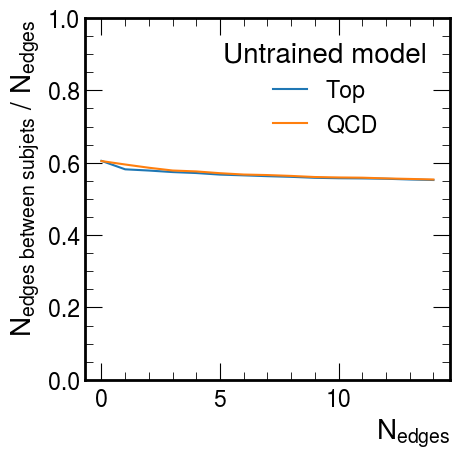

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(range(len(top_fraction_untrained)), top_fraction_untrained, label="Top")
ax.plot(range(len(qcd_fraction_untrained)), qcd_fraction_untrained, label="QCD")
ax.legend(title="Untrained model")
ax.set_xlabel(r"$N_{edges}$", fontsize=20)
ax.set_ylabel(r"$N_{edges \ between \ subjets}$ / $N_{edges}$", fontsize=20)
ax.set_ylim(0,1)
fig.tight_layout()
plt.savefig(f"paper/scaling_up_untrained.pdf")

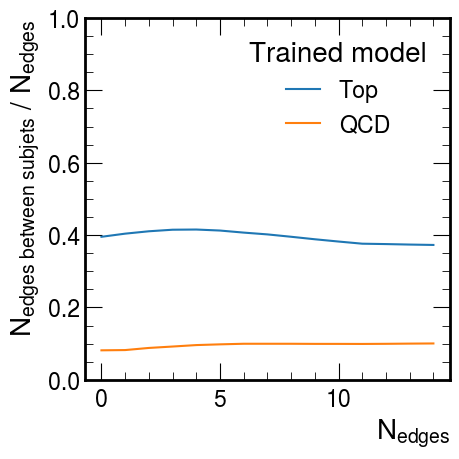

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(range(len(top_fraction_trained)), top_fraction_trained, label="Top")
ax.plot(range(len(qcd_fraction_trained)), qcd_fraction_trained, label="QCD")
ax.legend(title="Trained model")
ax.set_xlabel(r"$N_{edges}$", fontsize=20)
ax.set_ylabel(r"$N_{edges \ between \ subjets}$ / $N_{edges}$", fontsize=20)
ax.set_ylim(0,1)
fig.tight_layout()
plt.savefig(f"paper/scaling_up_trained.pdf")